In [1]:
%load_ext lab_black

# Spectral Kernel Approximations

In [2]:
import gpjax
from gpjax.gps import Prior
from gpjax.likelihoods import Gaussian
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.experimental import optimizers
import matplotlib.pyplot as plt

key = jr.PRNGKey(123)

In [3]:
def draw_gp_sample(key, N, n_train, kernel, params, noise=0.1):
    x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(N,)).sort().reshape(-1, 1)
    mean = jnp.zeros(N)
    cov = gpjax.kernels.gram(kernel, x, params) + gpjax.utils.I(N) * 1e-6
    y = jr.multivariate_normal(key, mean=mean, cov=cov)

    train_idx = jr.choice(
        key=key, a=jnp.arange(N), shape=(n_train,), replace=False
    ).sort()
    xtr = x[train_idx]
    ytr = y[train_idx]
    ytr += jr.normal(key, shape=ytr.shape) * noise
    return xtr, x, ytr, y

In [4]:
N = 2000
n_train = 1000
noise = 0.1
M = 100
x, xte, y, yte = draw_gp_sample(
    key,
    N,
    n_train,
    gpjax.kernels.RBF(),
    {"lengthscale": jnp.array(0.4), "variance": jnp.array(0.5)},
    noise,
)

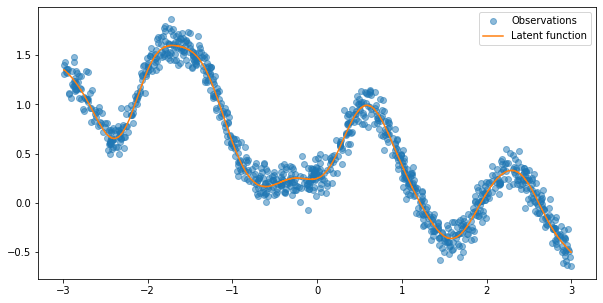

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y, "o", label="Observations", alpha=0.5)
ax.plot(xte, yte, label="Latent function")
ax.legend(loc="best")
# plt.savefig("data.png")

In [6]:
from gpjax.kernels import RBF, initialise
from gpjax.kernels.spectral import to_spectral

kernel = to_spectral(RBF(), M)
print(kernel)

Spectral RBF:
	 Number of basis functions: 100
	 Stationary: True 
	 ARD structure: False


In [7]:
from gpjax import Prior

prior = Prior(kernel=kernel)

In [8]:
from gpjax.likelihoods import Gaussian

posterior = prior * Gaussian()

In [9]:
print(posterior)

Sparse Spectral Posterior
--------------------------------------------------------------------------------
- Zero mean function
	 Output dimension: 1
- Spectral RBF:
	 Number of basis functions: 100
	 Stationary: True 
	 ARD structure: False
- Gaussian likelihood function


In [10]:
from gpjax.parameters import initialise, build_all_transforms
from gpjax.config import get_defaults

params = initialise(key, posterior)
sparams = {"basis_fns": params["basis_fns"]}
del params["basis_fns"]
constrain, unconstrain = build_all_transforms(params.keys(), get_defaults())

In [11]:
params = unconstrain(params)

In [12]:
from gpjax.objectives import marginal_ll
from jax import jit

mll = jit(marginal_ll(posterior, transform=constrain, negative=True))

In [13]:
mll(params, x, y, sparams)

DeviceArray(76812.51843461, dtype=float64)

In [14]:
opt_init, opt_update, get_params = optimizers.adam(step_size=0.05)
opt_state = opt_init(params)


def step(i, opt_state):
    p = get_params(opt_state)
    v, g = jax.value_and_grad(mll)(p, x, y, sparams)
    return opt_update(i, g, opt_state), v


nits = 300
mlls = []

for i in range(nits):
    opt_state, mll_estimate = step(i, opt_state)
    mlls.append(-mll_estimate)

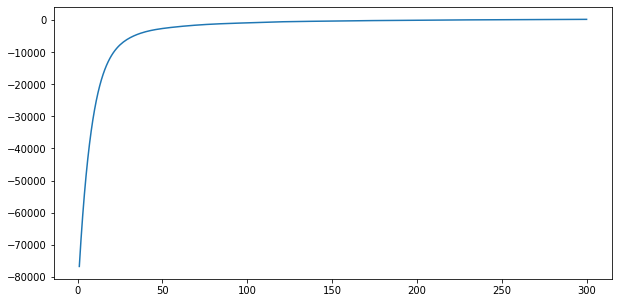

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, nits + 1), mlls)

In [16]:
final_params = constrain(get_params(opt_state))

In [17]:
from gpjax.sampling import random_variable

posterior_rv = random_variable(
    posterior, final_params, x, y, xte, static_params=sparams
)

(2000,)


In [18]:
final_params

{'lengthscale': DeviceArray([0.07086954], dtype=float64),
 'obs_noise': DeviceArray([2.45131987], dtype=float64),
 'variance': DeviceArray([0.22114532], dtype=float64)}

In [19]:
mu = posterior_rv.mean()
sigma = jnp.sqrt(jnp.diag(posterior_rv.covariance()))

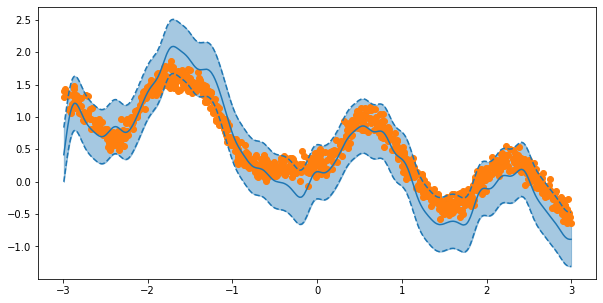

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y, "o", color="tab:orange")
ax.plot(xte, mu, color="tab:blue")
ax.fill_between(
    xte.ravel(),
    mu.ravel() - sigma,
    mu.ravel() + sigma,
    alpha=0.4,
    color="tab:blue",
)
ax.plot(xte, mu.ravel() - sigma, linestyle="--", color="tab:blue")
ax.plot(xte, mu.ravel() + sigma, linestyle="--", color="tab:blue")

## System information

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Mar 14 2021

Python implementation: CPython
Python version       : 3.8.7
IPython version      : 7.20.0

matplotlib: 3.3.4
jax       : 0.2.8
gpjax     : 0.3.3

Watermark: 2.2.0

